# Multi-omics Analysis of scRNA-seq and scATAC-seq Data

This script performs a multi-omics analysis using single-cell RNA sequencing (scRNA-seq) and single-cell ATAC sequencing (scATAC-seq) datasets from the GSE126074 study. The analysis includes data loading, preprocessing, visualization, and clustering using the MuData framework.

## Table of Contents
1. [Setup](#setup)
2. [Data Loading](#data-loading)
3. [Data Exploration](#data-exploration)
4. [Data Visualization](#data-visualization)
5. [Data Preprocessing](#data-preprocessing)
6. [Multi-omics Analysis](#multi-omics-analysis)
7. [Clustering and Visualization](#clustering-and-visualization)

## Setup

Import the necessary libraries:

```python

In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np  
import muon as mu  

import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

Define the paths to the dataset files and load the scRNA-seq and scATAC-seq data:

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Define the data path
data_path = os.path.join(current_dir, 'data', 'GSE126074')

# Define the file paths
rna_counts_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_cDNA.counts.mtx.gz')
rna_barcodes_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_cDNA.barcodes.tsv.gz')
rna_genes_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_cDNA.genes.tsv.gz')

atac_counts_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_chromatin.counts.mtx.gz')
atac_barcodes_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_chromatin.barcodes.tsv.gz')
atac_peaks_path = os.path.join(data_path, 'GSE126074_AdBrainCortex_SNAREseq_chromatin.peaks.tsv.gz')

# Load scRNA-seq data
adata_rna = sc.read_mtx(rna_counts_path)
barcodes_rna = pd.read_csv(rna_barcodes_path, header=None, sep='\t')
genes_rna = pd.read_csv(rna_genes_path, header=None, sep='\t')

# Load scATAC-seq data
adata_atac = sc.read_mtx(atac_counts_path)
barcodes_atac = pd.read_csv(atac_barcodes_path, header=None, sep='\t')
peaks_atac = pd.read_csv(atac_peaks_path, header=None, sep='\t')

## Data Exploration

Print the first few rows of the genes and peaks DataFrames to understand their structure:

In [3]:
# Print the first few rows of the genes and peaks DataFrames to understand their structure
print("Genes DataFrame:")
print(genes_rna.head())
print("\nPeaks DataFrame:")
print(peaks_atac.head())

Genes DataFrame:
               0
0  0610005C13Rik
1  0610007P14Rik
2  0610009B22Rik
3  0610009E02Rik
4  0610009L18Rik

Peaks DataFrame:
                      0
0  chr1:3005833-3005982
1  chr1:3094772-3095489
2  chr1:3119556-3120739
3  chr1:3121334-3121696
4  chr1:3134637-3135032


## Data Visualization

Plot gene expression and peak accessibility distributions for scRNA-seq and scATAC-seq data:

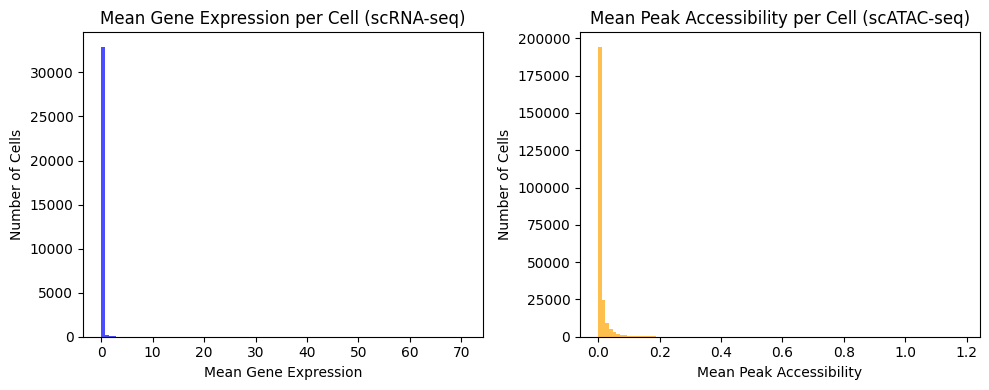

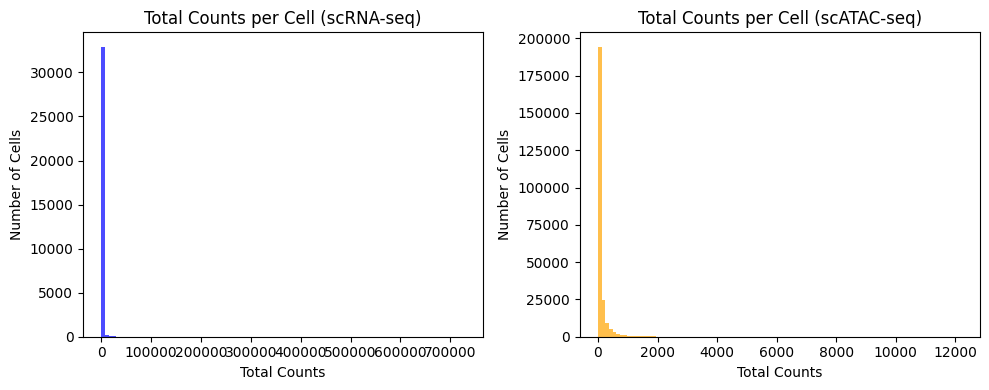

In [4]:
# Plot gene expression distributions for scRNA-seq data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(adata_rna.X.mean(axis=1), bins=100, alpha=0.7, color='blue')
plt.title('Mean Gene Expression per Cell (scRNA-seq)')
plt.xlabel('Mean Gene Expression')
plt.ylabel('Number of Cells')

# Plot peak accessibility distributions for scATAC-seq data
plt.subplot(1, 2, 2)
plt.hist(adata_atac.X.mean(axis=1), bins=100, alpha=0.7, color='orange')
plt.title('Mean Peak Accessibility per Cell (scATAC-seq)')
plt.xlabel('Mean Peak Accessibility')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

# Plot total counts per cell for scRNA-seq data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(adata_rna.X.sum(axis=1), bins=100, alpha=0.7, color='blue')
plt.title('Total Counts per Cell (scRNA-seq)')
plt.xlabel('Total Counts')
plt.ylabel('Number of Cells')

# Plot total counts per cell for scATAC-seq data
plt.subplot(1, 2, 2)
plt.hist(adata_atac.X.sum(axis=1), bins=100, alpha=0.7, color='orange')
plt.title('Total Counts per Cell (scATAC-seq)')
plt.xlabel('Total Counts')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

**Histogram Interpretation:**

Both mean gene expression and mean peak accessibility per cell show a strong concentration of values near zero, with a long tail extending to higher values.

**Next Step:**

We will use the boxplot to check for outliers.

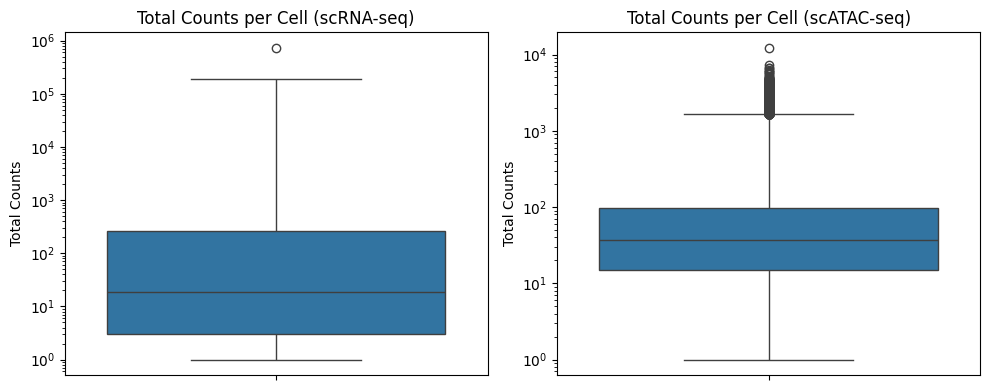

In [5]:
# Calculate total counts per cell for scRNA-seq data
adata_rna.obs['total_counts'] = adata_rna.X.sum(axis=1)

# Calculate total counts per cell for scATAC-seq data
adata_atac.obs['total_counts'] = adata_atac.X.sum(axis=1)

# Plot box plots for scRNA-seq data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=adata_rna.obs['total_counts'], log_scale=True)
plt.title('Total Counts per Cell (scRNA-seq)')
plt.ylabel('Total Counts')

# Plot box plots for scATAC-seq data
plt.subplot(1, 2, 2)
sns.boxplot(y=adata_atac.obs['total_counts'], log_scale=True)
plt.title('Total Counts per Cell (scATAC-seq)')
plt.ylabel('Total Counts')
plt.tight_layout()
plt.show()

**Boxplot Interpretation:**

There is one outlier for the scRNA-seq data and there are a number of outliers for the scATAC-seq data.

**Next Step:**

Next we log transformed the data and used violin plots on the scRNA-seq and scATAC-seq data.

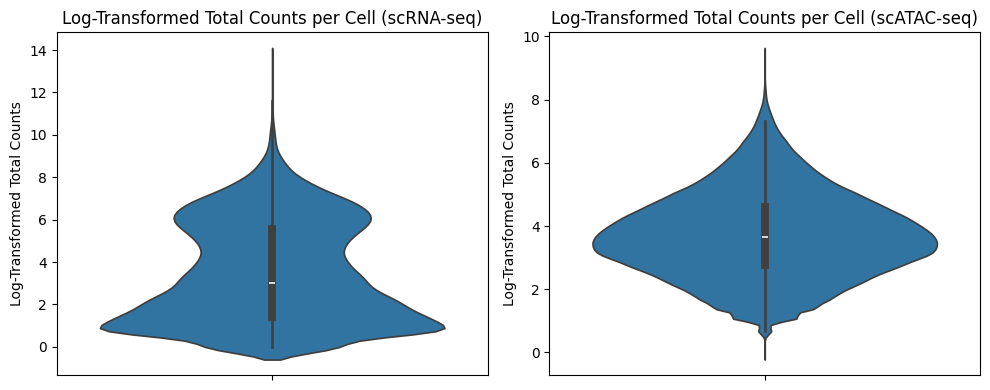

In [6]:
# Calculate total counts per cell for scRNA-seq data
adata_rna.obs['total_counts'] = adata_rna.X.sum(axis=1)

# Calculate total counts per cell for scATAC-seq data
adata_atac.obs['total_counts'] = adata_atac.X.sum(axis=1)

# Log-transform the total counts and remove infs and NaNs
adata_rna.obs['log_total_counts'] = np.log1p(adata_rna.obs['total_counts']).replace([np.inf, -np.inf], np.nan).dropna()
adata_atac.obs['log_total_counts'] = np.log1p(adata_atac.obs['total_counts']).replace([np.inf, -np.inf], np.nan).dropna()

# Plot violin plots for scRNA-seq data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.violinplot(y=adata_rna.obs['log_total_counts'])
plt.title('Log-Transformed Total Counts per Cell (scRNA-seq)')
plt.ylabel('Log-Transformed Total Counts')

# Plot violin plots for scATAC-seq data
plt.subplot(1, 2, 2)
sns.violinplot(y=adata_atac.obs['log_total_counts'])
plt.title('Log-Transformed Total Counts per Cell (scATAC-seq)')
plt.ylabel('Log-Transformed Total Counts')
plt.tight_layout()
plt.show()

Ensure the data is correctly oriented and create AnnData objects:

In [7]:
# Ensure the data is correctly oriented
if adata_rna.shape[0] != len(barcodes_rna):
    adata_rna = adata_rna.T
if adata_atac.shape[0] != len(barcodes_atac):
    adata_atac = adata_atac.T

Ensure barcodes match between scRNA-seq and scATAC-seq and create a MuData object for multi-omics analysis:

In [8]:
# Create AnnData objects
adata_rna.obs_names = barcodes_rna[0].values
adata_rna.var_names = genes_rna[0].values

adata_atac.obs_names = barcodes_atac[0].values
adata_atac.var_names = peaks_atac[0].values

# Ensure barcodes match between scRNA-seq and scATAC-seq
common_barcodes = adata_rna.obs_names.intersection(adata_atac.obs_names)
adata_rna = adata_rna[adata_rna.obs_names.isin(common_barcodes), :].copy()  # Create a copy
adata_atac = adata_atac[adata_atac.obs_names.isin(common_barcodes), :].copy()  # Create a copy

# Create a MuData object for multi-omics analysis
mdata = mu.MuData({'rna': adata_rna, 'atac': adata_atac})

a:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\mudata\_core\mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
a:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\mudata\_core\mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## Multi-omics Analysis

Perform multi-omics analysis, including preprocessing, dimensionality reduction, and clustering:

In [9]:
# Perform multi-omics analysis
mu.pp.intersect_obs(mdata)

# Apply scanpy preprocessing functions to each modality
for modality in mdata.mod.keys():
    sc.pp.log1p(mdata[modality])
    sc.pp.scale(mdata[modality], max_value=10)
    sc.pp.pca(mdata[modality], svd_solver='arpack')
    sc.pp.neighbors(mdata[modality], n_neighbors=10, n_pcs=40)

# Ensure neighbors are computed for the integrated data
mu.pp.neighbors(mdata)

# Perform UMAP on the integrated data
mu.tl.umap(mdata)

a:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\mudata\_core\mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
a:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\mudata\_core\mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [10]:
# Compute clusters using the Leiden algorithm if no metadata is available
mu.tl.leiden(mdata)

## Clustering and Visualization

Visualize the results using UMAP and color by clusters:

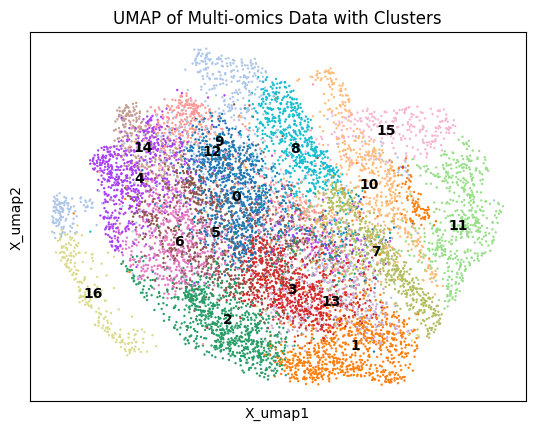

In [11]:
# Visualize
# mu.pl.umap(mdata)

# Visualize with improved labels, coloring by clusters
mu.pl.umap(mdata, color='leiden', legend_loc='on data', legend_fontsize=10, title='UMAP of Multi-omics Data with Clusters', show=True)